In [1]:
from collections import namedtuple
import pickle
import random

from gym.wrappers import RescaleAction, TimeLimit
import json
from matplotlib.patches import Ellipse
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from stable_baselines3 import PPO, TD3
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from tqdm import tqdm

from environments import ARESEAOneStep, ARESEASequential

# Sequential

In [2]:
def load_sequential(model_name):

    ModelSetup = namedtuple("ModelSetup", ["name","env","model"])

    log_dir = f"models/{model_name}"

    def make_env():
        env = ARESEASequential(
            backend="simulation",
            backendargs={"measure_beam": "direct"}
        )
        env = TimeLimit(env, max_episode_steps=300)
        env = RescaleAction(env, -1, 1)
        return env

    env = DummyVecEnv([make_env])
    env = VecNormalize.load(f"{log_dir}/vec_normalize.pkl", env)
    env.training = False
    env.norm_reward = False

    model = TD3.load(f"{log_dir}/model")

    return ModelSetup(model_name, env, model)

In [3]:
def pack_dataframe(fn):
    def wrapper(setup, problem=None):
        observations, rewards, incoming, misalignments = fn(setup, problem=problem)
        observations = np.array(observations)

        df = pd.DataFrame(np.arange(len(observations)), columns=["step"])
        df["q1"] = observations[:,0]
        df["q2"] = observations[:,1]
        df["cv"] = observations[:,2]
        df["q3"] = observations[:,3]
        df["ch"] = observations[:,4]
        df["mup_x"] = observations[:,5]
        df["mup_y"] = observations[:,6]
        df["sigmap_x"] = observations[:,7]
        df["sigmap_y"] = observations[:,8]
        df["mu_x"] = observations[:,9]
        df["mu_y"] = observations[:,10]
        df["sigma_x"] = observations[:,11]
        df["sigma_y"] = observations[:,12]
        df["reward"] = [np.nan] + rewards
        for k in incoming.keys():
            df["incoming_"+k] = float(incoming[k])
        df["misalignment_q1"] = misalignments[0]
        df["misalignment_q2"] = misalignments[1]
        df["misalignment_q3"] = misalignments[2]
        df["misalignment_screen"] = misalignments[4]

        return df
    
    return wrapper

In [4]:
@pack_dataframe
def run(setup, problem=None):
    env, model = setup.env, setup.model

    if problem is not None:
        if "initial" in problem:
            env.get_attr("unwrapped")[0].next_initial = problem["initial"]
        if "incoming" in problem:
            env.get_attr("backend")[0].next_incoming = problem["incoming"]
        if "misalignments" in problem:
            env.get_attr("backend")[0].next_misalignments = problem["misalignments"]
        if "desired" in problem:
            env.get_attr("unwrapped")[0].next_desired = problem["desired"]

    observations = []
    rewards = []

    observation = env.reset()

    observations.append(env.unnormalize_obs(observation).squeeze())
    incoming = env.get_attr("backend")[0]._incoming.parameters
    misalignments = env.get_attr("backend")[0].misalignments

    done = False
    while not done:
        action, _ = model.predict(observation, deterministic=True)
        observation, reward, done, info = env.step(action)

        observations.append(env.unnormalize_obs(observation).squeeze())
        rewards.append(reward.squeeze())

    observations[-1] = env.unnormalize_obs(info[0]["terminal_observation"].squeeze())

    return observations, rewards, incoming, misalignments

In [5]:
def cache_to_file(fn):
    def wrapper(model_name, **kwargs):
        filename = f".cache/{model_name}.pkl"
        
        try:
            evaluation = pd.read_pickle(filename)
            print(f"Read {model_name} from cache file")
        except FileNotFoundError:
            evaluation = fn(model_name, **kwargs)
            evaluation.to_pickle(filename)
        
        return evaluation

    return wrapper

In [6]:
@cache_to_file
def evaluate(model_name, method=None):
    setup = load_sequential(model_name)

    with open("problems.json", "r") as f:
        problems = json.load(f)

    evaluation = []
    for i, problem in enumerate(tqdm(problems)):
        result = run(setup, problem=problem)
        result["problem_index"] = i
        evaluation.append(result)
    evaluation = pd.concat(evaluation)
    evaluation["model"] = setup.name
    if method is not None:
        evaluation["method"] = method
    
    return evaluation

In [7]:
def plot_examples(evaluation, k=3):
    samples = random.sample(evaluation.results, k)

    def plot_ellipse(params, color=None, label=None):
        ellipse = Ellipse((params[0],params[1]), params[2], params[3], fill=False, color=color, label=label)
        plt.gca().add_patch(ellipse)

    screen = evaluation.env.get_attr("backend")[0]._segment.AREABSCR1

    plt.figure(figsize=(21,4))
    plt.suptitle(f"Example runs of {evaluation.model_name}")
    for i, sample in enumerate(samples):
        plt.subplot(1, len(samples), i+1)
        plt.title(f"Run {i+1}")
        plt.xlim([screen.extent[0], screen.extent[1]])
        plt.ylim([screen.extent[2], screen.extent[3]])
        plt.xlabel("x (m)")
        plt.ylabel("y (m)")
        plt.grid()
        plot_ellipse(sample.initial, color="red", label="Initial")
        plot_ellipse(sample.achieved, color="orange", label="Achieved")
        plot_ellipse(sample.desired, color="green", label="Desired")        
        plt.legend()

In [8]:
def plot_our_objective(evaluations, model_type=None):

    def objective_fn(achieved, desired):
        offset = achieved - desired
        weights = np.array([1, 1, 2, 2])

        return np.log((weights * np.abs(offset)).sum())
    
    plt.figure(figsize=(18,4.5))

    if model_type is not None:
        plt.suptitle(f"Our Objective for {model_type}")
    else:
        plt.suptitle(f"Our Objective")
        
    for i, evaluation in enumerate(evaluations):
        objectives = [objective_fn(result.achieved, result.desired) for result in evaluation.results]

        plt.subplot(1, len(evaluations), i+1)
        plt.title(evaluation.model_name)
        sns.histplot(objectives, bins=20, kde=True)
        plt.xlabel("Achieved Objective")
    plt.tight_layout()
    plt.show()

In [9]:
def plot_mae(evaluations, model_type=None):
    plt.figure(figsize=(18,4.5))

    if model_type is not None:
        plt.suptitle(f"Our Objective for {model_type}")
    else:
        plt.suptitle(f"Our Objective")
        
    for i, evaluation in enumerate(evaluations):
        objectives = [np.abs(result.desired - result.achieved).sum() / 4 for result in evaluation.results]
        
        plt.subplot(1, len(evaluations), i+1)
        plt.title(evaluation.model_name)
        sns.histplot(objectives, bins=20, kde=True)
        plt.xlabel("Achieved Objective")
        plt.xscale("log")
    plt.tight_layout()
    plt.show()

In [10]:
def plot_parameter_errors(results):
    pass

In [11]:
todos = {
    "Trained with Random Initial and No Misalignments for 600k Steps": [
        "bright-rain-963", "lyric-wave-964", "pleasant-wood-965"
    ],
    "Trained 600k With Initial Actuators Set to Zero": [
        "faithful-meadow-975", "amber-mountain-976", "ruby-water-977"
    ],
    "Quadrupole and Screen Misalignments (Up to 400 Micrometers in Both Directions)": [
        "ethereal-firefly-972", "royal-planet-973", "clear-armadillo-974"
    ],
    "Training for 6M Steps": [
        "visionary-blaze-969", "vibrant-leaf-970", "electric-sun-971"
    ]
}

evaluation = pd.concat([
    evaluate(model_name, method=method) for method in todos.keys() for model_name in todos[method]
])

Read bright-rain-963 from cache file
Read lyric-wave-964 from cache file
Read pleasant-wood-965 from cache file
Read faithful-meadow-975 from cache file
Read amber-mountain-976 from cache file
Read ruby-water-977 from cache file
Read ethereal-firefly-972 from cache file
Read royal-planet-973 from cache file
Read clear-armadillo-974 from cache file
Read visionary-blaze-969 from cache file
Read vibrant-leaf-970 from cache file
Read electric-sun-971 from cache file


In [12]:
# Compute MAE
evaluation["delta_mu_x"] = np.abs(evaluation["mup_x"] - evaluation["mu_x"])
evaluation["delta_mu_y"] = np.abs(evaluation["mup_x"] - evaluation["mu_x"])
evaluation["delta_sigma_x"] = np.abs(evaluation["sigmap_x"] - evaluation["sigma_x"])
evaluation["delta_sigma_y"] = np.abs(evaluation["sigmap_y"] - evaluation["sigma_y"])
evaluation["MAE"] = (evaluation["delta_mu_x"] + evaluation["delta_mu_y"] + evaluation["delta_sigma_x"] + evaluation["delta_sigma_y"]) / 4

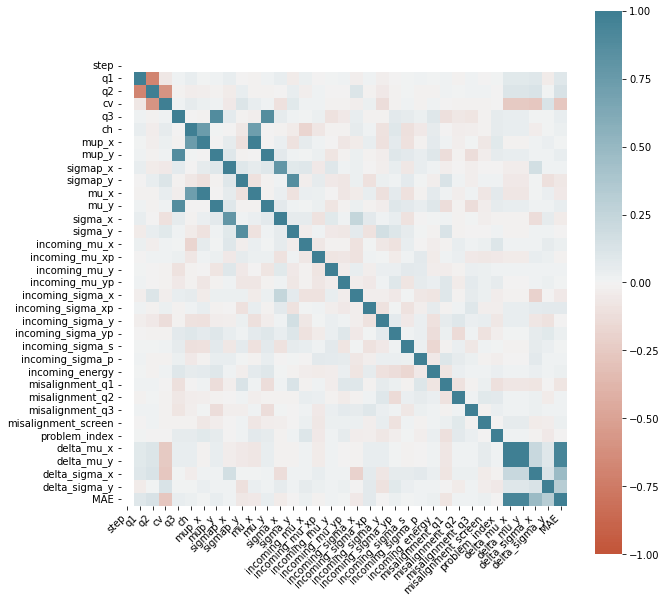

In [16]:
plt.figure(figsize=(10,10))
corr = evaluation[evaluation["step"] == 50].corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
plt.show()

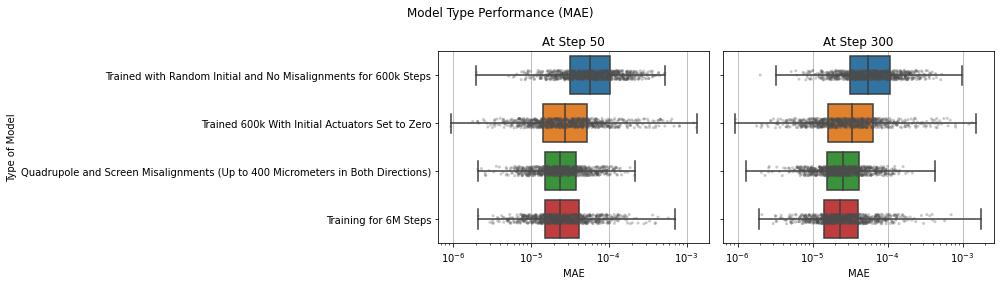

In [49]:
plt.figure(figsize=(14,4))
plt.suptitle("Model Type Performance (MAE)")
plt.subplot(121)
plt.title("At Step 50")
sns.boxplot(x="MAE", y="method", whis=(0,100), data=evaluation[evaluation["step"]==50])
sns.stripplot(x="MAE", y="method", size=3, color=".3", alpha=0.3, linewidth=0, data=evaluation[evaluation["step"]==50])
plt.xscale("log")
plt.xlabel("MAE")
plt.ylabel("Type of Model")
plt.gca().xaxis.grid()
plt.gca().set_axisbelow(True)
plt.subplot(122)
plt.title("At Step 300")
sns.boxplot(x="MAE", y="method", whis=(0,100), data=evaluation[evaluation["step"]==300])
sns.stripplot(x="MAE", y="method", size=3, color=".3", alpha=0.3, linewidth=0, data=evaluation[evaluation["step"]==50])
plt.xscale("log")
plt.xlabel("MAE")
plt.ylabel("")
plt.gca().xaxis.grid()
plt.gca().set_axisbelow(True)
plt.gca().set_yticklabels([])
plt.tight_layout()
plt.show()

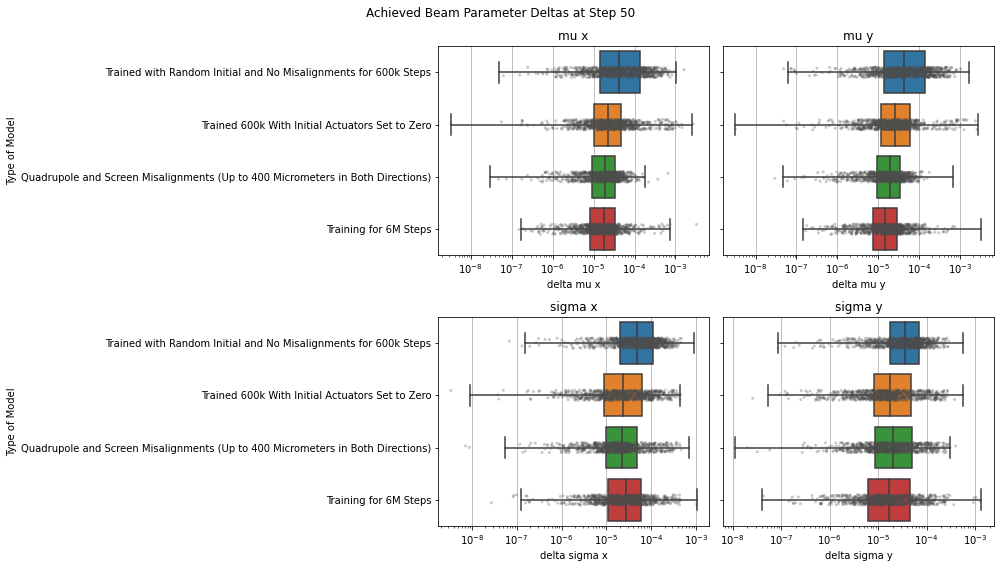

In [56]:
plt.figure(figsize=(14,8))
plt.suptitle("Achieved Beam Parameter Deltas at Step 50")
plt.subplot(221)
plt.title("mu x")
sns.boxplot(x="delta_mu_x", y="method", whis=(0,100), data=evaluation[evaluation["step"]==50])
sns.stripplot(x="delta_mu_x", y="method", size=3, color=".3", alpha=0.3, linewidth=0, data=evaluation[evaluation["step"]==300])
plt.xscale("log")
plt.xlabel("delta mu x")
plt.ylabel("Type of Model")
plt.gca().xaxis.grid()
plt.gca().set_axisbelow(True)
plt.subplot(222)
plt.title("mu y")
sns.boxplot(x="delta_mu_y", y="method", whis=(0,100), data=evaluation[evaluation["step"]==300])
sns.stripplot(x="delta_mu_y", y="method", size=3, color=".3", alpha=0.3, linewidth=0, data=evaluation[evaluation["step"]==50])
plt.xscale("log")
plt.xlabel("delta mu y")
plt.ylabel("")
plt.gca().xaxis.grid()
plt.gca().set_axisbelow(True)
plt.gca().set_yticklabels([])
plt.subplot(223)
plt.title("sigma x")
sns.boxplot(x="delta_sigma_x", y="method", whis=(0,100), data=evaluation[evaluation["step"]==300])
sns.stripplot(x="delta_sigma_x", y="method", size=3, color=".3", alpha=0.3, linewidth=0, data=evaluation[evaluation["step"]==50])
plt.xscale("log")
plt.xlabel("delta sigma x")
plt.ylabel("Type of Model")
plt.gca().xaxis.grid()
plt.gca().set_axisbelow(True)
plt.subplot(224)
plt.title("sigma y")
sns.boxplot(x="delta_sigma_y", y="method", whis=(0,100), data=evaluation[evaluation["step"]==300])
sns.stripplot(x="delta_sigma_y", y="method", size=3, color=".3", alpha=0.3, linewidth=0, data=evaluation[evaluation["step"]==50])
plt.xscale("log")
plt.xlabel("delta sigma y")
plt.ylabel("")
plt.gca().xaxis.grid()
plt.gca().set_axisbelow(True)
plt.gca().set_yticklabels([])
plt.tight_layout()
plt.show()

In [67]:
evaluation[evaluation["model"]=="amber-mountain-976"]

,step,q1,q2,cv,q3,ch,mup_x,mup_y,sigmap_x,sigmap_y,...,misalignment_q3,misalignment_screen,problem_index,model,method,delta_mu_x,delta_mu_y,delta_sigma_x,delta_sigma_y,MAE
0,0,-8.423128e-08,8.022620e-09,1.958620e-08,1.964785e-14,6.518805e-13,0.001002,-0.001074,0.000355,0.000329,...,0.000349,0.000288,0,amber-mountain-976,Trained 600k With Initial Actuators Set to Zero,0.000561,0.000561,8.878408e-04,0.000284,0.000573
1,1,1.501223e+00,2.575051e+00,3.000000e+00,-2.999892e-04,6.000000e-04,0.001002,-0.001074,0.000355,0.000329,...,0.000349,0.000288,0,amber-mountain-976,Trained 600k With Initial Actuators Set to Zero,0.000505,0.000505,1.599761e-04,0.000255,0.000356
2,2,1.806717e+00,2.807885e+00,4.595586e+00,-5.999768e-04,1.199852e-03,0.001002,-0.001074,0.000355,0.000329,...,0.000349,0.000288,0,amber-mountain-976,Trained 600k With Initial Actuators Set to Zero,0.000281,0.000281,3.013043e-04,0.000245,0.000277
3,3,4.132447e+00,1.370817e+00,7.468312e+00,-8.998877e-04,1.793981e-03,0.001002,-0.001074,0.000355,0.000329,...,0.000349,0.000288,0,amber-mountain-976,Trained 600k With Initial Actuators Set to Zero,0.000088,0.000088,2.018235e-05,0.000226,0.000106
4,4,3.452554e+00,1.230283e+00,6.528286e+00,-1.195595e-03,2.138021e-03,0.001002,-0.001074,0.000355,0.000329,...,0.000349,0.000288,0,amber-mountain-976,Trained 600k With Initial Actuators Set to Zero,0.000102,0.000102,1.418936e-04,0.000236,0.000146
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296,296,-5.647629e+00,6.237463e-01,1.537559e+01,-8.198297e-04,-1.956809e-03,-0.000169,-0.001444,0.000031,0.000424,...,0.000355,0.000261,299,amber-mountain-976,Trained 600k With Initial Actuators Set to Zero,0.000010,0.000010,9.268942e-07,0.000005,0.000006
297,297,-5.647627e+00,6.237467e-01,1.537559e+01,-8.198296e-04,-1.956810e-03,-0.000169,-0.001444,0.000031,0.000424,...,0.000355,0.000261,299,amber-mountain-976,Trained 600k With Initial Actuators Set to Zero,0.000010,0.000010,9.269291e-07,0.000005,0.000006
298,298,-5.647629e+00,6.237467e-01,1.537559e+01,-8.198296e-04,-1.956809e-03,-0.000169,-0.001444,0.000031,0.000424,...,0.000355,0.000261,299,amber-mountain-976,Trained 600k With Initial Actuators Set to Zero,0.000010,0.000010,9.269291e-07,0.000005,0.000006
299,299,-5.647627e+00,6.237453e-01,1.537559e+01,-8.198295e-04,-1.956808e-03,-0.000169,-0.001444,0.000031,0.000424,...,0.000355,0.000261,299,amber-mountain-976,Trained 600k With Initial Actuators Set to Zero,0.000010,0.000010,9.269291e-07,0.000005,0.000006


In [62]:
evaluation[evaluation["model"]=="amber-mountain-976"&evaluation["problem_index"]==42]

TypeError: Cannot perform 'rand_' with a dtyped [int64] array and scalar of type [bool]

In [61]:
sns.lineplot(x="step", y="MAE", data=evaluation[evaluation["model"]=="amber-mountain-976"&evaluation["problem_index"]==42])
plt.show()

TypeError: Cannot perform 'rand_' with a dtyped [int64] array and scalar of type [bool]

In [73]:
evaluation[evaluation["step"].isin([50,300])].groupby(["model","problem_index"])["step","MAE"].max()

,step,q1,q2,cv,q3,ch,mup_x,mup_y,sigmap_x,sigmap_y,...,misalignment_q3,misalignment_screen,problem_index,model,method,delta_mu_x,delta_mu_y,delta_sigma_x,delta_sigma_y,MAE
50,50,5.875933,-3.986606,12.653728,-0.001166,0.002115,0.001002,-0.001074,0.000355,0.000329,...,0.000349,0.000288,0,bright-rain-963,Trained with Random Initial and No Misalignmen...,0.000031,0.000031,0.000035,0.000232,0.000082
300,300,5.918628,-4.174272,12.831249,-0.001147,0.002119,0.001002,-0.001074,0.000355,0.000329,...,0.000349,0.000288,0,bright-rain-963,Trained with Random Initial and No Misalignmen...,0.000032,0.000032,0.000035,0.000233,0.000083
50,50,3.131847,-11.260047,11.840614,0.000165,0.003935,0.001324,0.000204,0.000433,0.000405,...,-0.000390,-0.000284,1,bright-rain-963,Trained with Random Initial and No Misalignmen...,0.000032,0.000032,0.000012,0.000089,0.000041
300,300,-0.039239,-9.005188,13.965829,0.000077,0.004787,0.001324,0.000204,0.000433,0.000405,...,-0.000390,-0.000284,1,bright-rain-963,Trained with Random Initial and No Misalignmen...,0.000006,0.000006,0.000016,0.000138,0.000041
50,50,7.069132,-5.178199,14.285968,-0.002056,-0.003264,-0.001440,-0.001399,0.000341,0.000377,...,-0.000083,-0.000069,2,bright-rain-963,Trained with Random Initial and No Misalignmen...,0.000027,0.000027,0.000003,0.000262,0.000080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300,300,-2.157167,17.786610,-20.083872,-0.001115,-0.004309,0.001104,-0.000121,0.000218,0.000060,...,-0.000076,0.000206,297,electric-sun-971,Training for 6M Steps,0.000033,0.000033,0.000009,0.000018,0.000023
50,50,-5.108279,11.824284,-8.632574,0.002099,-0.005767,-0.000771,0.001647,0.000402,0.000400,...,0.000241,-0.000287,298,electric-sun-971,Training for 6M Steps,0.000057,0.000057,0.000045,0.000010,0.000043
300,300,-6.573340,9.309215,1.966287,0.001784,-0.004522,-0.000771,0.001647,0.000402,0.000400,...,0.000241,-0.000287,298,electric-sun-971,Training for 6M Steps,0.000020,0.000020,0.000064,0.000006,0.000028
50,50,-7.667497,12.286231,-1.909689,-0.000845,-0.003608,-0.000169,-0.001444,0.000031,0.000424,...,0.000355,0.000261,299,electric-sun-971,Training for 6M Steps,0.000029,0.000029,0.000049,0.000007,0.000029


In [76]:
evaluation[evaluation["step"].isin([50,300])]# .groupby(["model","problem_index"])["step","MAE"].max().aggregate(lambda x: x.sort_values("step", inplace=True)[-1] - x.sort_values("step", inplace=True)[0])

,step,q1,q2,cv,q3,ch,mup_x,mup_y,sigmap_x,sigmap_y,...,misalignment_q3,misalignment_screen,problem_index,model,method,delta_mu_x,delta_mu_y,delta_sigma_x,delta_sigma_y,MAE
50,50,5.875933,-3.986606,12.653728,-0.001166,0.002115,0.001002,-0.001074,0.000355,0.000329,...,0.000349,0.000288,0,bright-rain-963,Trained with Random Initial and No Misalignmen...,0.000031,0.000031,0.000035,0.000232,0.000082
300,300,5.918628,-4.174272,12.831249,-0.001147,0.002119,0.001002,-0.001074,0.000355,0.000329,...,0.000349,0.000288,0,bright-rain-963,Trained with Random Initial and No Misalignmen...,0.000032,0.000032,0.000035,0.000233,0.000083
50,50,3.131847,-11.260047,11.840614,0.000165,0.003935,0.001324,0.000204,0.000433,0.000405,...,-0.000390,-0.000284,1,bright-rain-963,Trained with Random Initial and No Misalignmen...,0.000032,0.000032,0.000012,0.000089,0.000041
300,300,-0.039239,-9.005188,13.965829,0.000077,0.004787,0.001324,0.000204,0.000433,0.000405,...,-0.000390,-0.000284,1,bright-rain-963,Trained with Random Initial and No Misalignmen...,0.000006,0.000006,0.000016,0.000138,0.000041
50,50,7.069132,-5.178199,14.285968,-0.002056,-0.003264,-0.001440,-0.001399,0.000341,0.000377,...,-0.000083,-0.000069,2,bright-rain-963,Trained with Random Initial and No Misalignmen...,0.000027,0.000027,0.000003,0.000262,0.000080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300,300,-2.157167,17.786610,-20.083872,-0.001115,-0.004309,0.001104,-0.000121,0.000218,0.000060,...,-0.000076,0.000206,297,electric-sun-971,Training for 6M Steps,0.000033,0.000033,0.000009,0.000018,0.000023
50,50,-5.108279,11.824284,-8.632574,0.002099,-0.005767,-0.000771,0.001647,0.000402,0.000400,...,0.000241,-0.000287,298,electric-sun-971,Training for 6M Steps,0.000057,0.000057,0.000045,0.000010,0.000043
300,300,-6.573340,9.309215,1.966287,0.001784,-0.004522,-0.000771,0.001647,0.000402,0.000400,...,0.000241,-0.000287,298,electric-sun-971,Training for 6M Steps,0.000020,0.000020,0.000064,0.000006,0.000028
50,50,-7.667497,12.286231,-1.909689,-0.000845,-0.003608,-0.000169,-0.001444,0.000031,0.000424,...,0.000355,0.000261,299,electric-sun-971,Training for 6M Steps,0.000029,0.000029,0.000049,0.000007,0.000029


In [81]:
evaluation[evaluation["step"] == 300]["MAE"].reset_index() - evaluation[evaluation["step"] == 50]["MAE"].reset_index()

,index,MAE
0,250.0,6.374320e-07
1,250.0,-1.051058e-07
2,250.0,-1.139979e-05
3,250.0,-1.373432e-05
4,250.0,3.017128e-06
...,...,...
3560,NaN,NaN
3561,NaN,NaN
3562,NaN,NaN
3563,NaN,NaN


In [89]:
evaluation.groupby(["model","problem_index"]).aggregate(len)["MAE"].sort_values()

model                 problem_index
ruby-water-977        100                8
vibrant-leaf-970      178                9
electric-sun-971      272               12
vibrant-leaf-970      17                12
amber-mountain-976    27                13
                                      ... 
ethereal-firefly-972  25               301
                      26               301
                      27               301
                      16               301
visionary-blaze-969   299              301
Name: MAE, Length: 3600, dtype: int64

<AxesSubplot:>

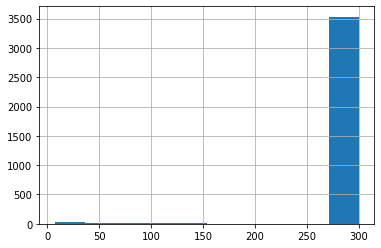

In [107]:
max_steps = evaluation.groupby(["model","problem_index"])["step"].max()
max_steps.hist()

In [102]:
test = evaluation.set_index(["model","problem_index"])
test["max_steps"] = max_steps

In [ ]:
test["max_steps"]

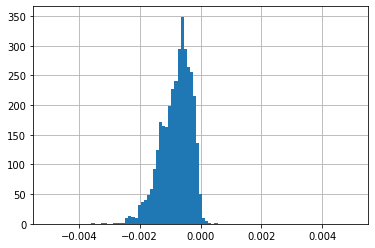

In [130]:
(test[(test["max_steps"] == 300) & (test["step"] == 300)]["MAE"] - test[(test["max_steps"] == 300) & (test["step"] == 1)]["MAE"]).hist(bins=np.linspace(-5e-3, 5e-3, num=100))
plt.gca().set_axisbelow(True)
plt.show()

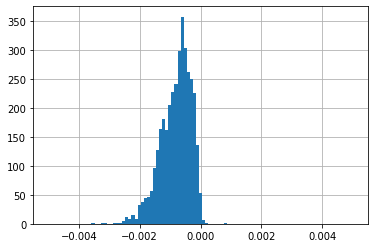

In [133]:
(test[(test["max_steps"] >= 50) & (test["step"] == 50)]["MAE"] - test[(test["max_steps"] >= 50) & (test["step"] == 1)]["MAE"]).hist(bins=np.linspace(-5e-3, 5e-3, num=100))
plt.gca().set_axisbelow(True)
plt.show()

In [134]:
(test[(test["max_steps"] >= 50) & (test["step"] == 50)]["MAE"] - test[(test["max_steps"] >= 50) & (test["step"] == 1)]["MAE"]).describe()

count    3565.000000
mean       -0.000809
std         0.000499
min        -0.003510
25%        -0.001130
50%        -0.000720
75%        -0.000437
max         0.000830
Name: MAE, dtype: float64